## AOS 527 Class Project

### Imports

In [681]:
# Numerical analysis packages
import numpy as np
import pandas as pd
# Visualization packages
import matplotlib.pyplot as plt
# Auxiliary packages
import os

### Auxiliary functions

#### Derive the band-averaged wavenumber

In [754]:
def band_info(band=None):
    # Define headers
    header = ['band', 'min', 'max']
    # Import data and set index to be band number
    bands = pd.read_csv('data/bands_info.csv', names=header).set_index('band')
    # Adjust units from cm^-1 to m^-1
    bands = bands*100
    # Calculate mean across each band
    bands['mean'] = bands.mean(axis=1)

    if band == 'all':
        return bands
    else:
        return bands.iloc[band-1]

#### Get gas names

In [755]:
def gas_names():
    ''' Method to load names of gases for which data is available. '''
    
    # Define folder name where data files are stored
    dirname = 'data'
    # Get unique gas names
    gases = sorted(set([os.path.join(dirname, file).split('_')[-2] for file in os.listdir(dirname) if 'CIRC' in file]))
    
    return gases

#### Import files and build data structure

In [756]:
def load(gas_name='ALLGAS', atmosphere='CIRC2'):
    ''' Method to load line-by-line transmittance data.
    
    Inputs:
        - gas_name: Name of the gas for which data will be loaded. Default is 'ALLGAS'.
        - atmosphere: Name of the CIRC profile data will be loaded for.
    Outputs:
        - gas_data: Pandas Dataframe with data for the selected gas.
        
    '''

    # Define folder name where data files are stored
    dirname = 'data'
    # Get all paths for files where data that meets criteria is stored
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) if (gas_name in file) and (atmosphere in file)]
    # Define column header names (see project description document)
    header = ['tb_{0}'.format(i-1) for i in range(2, 14+2)]
    header.insert(0, 'layer_pres')
    header.insert(0, 'layer_temp')
    # Initialize output Dataframe
    gas_data = []
    # Fill Dataframe iteratively (iteration used to construct auxiliary data columns)
    for file in files:
        # Load data
        tmp = pd.read_csv(file, sep='\s+', names=header)
        # Add column with atmospheric profile of data
        tmp['atm_profile'] = file.split('/')[-1].split('_')[0]
        # Add column with gas name
        tmp['gas'] = file.split('/')[-1].split('_')[-2]
        # Add column with level
        tmp['level'] = file.split('.')[0].split('_')[-1]
        # Append to list
        gas_data.append(tmp)
    # Concatenate Dataframes
    gas_data = pd.concat(gas_data).reset_index(drop=True)
    
    return gas_data

#### Planck function
Reference: Goody, Eq. 2.38

In [757]:
def B_lambda(T, lambda_=None):
    ''' 
    Planck function for a given temperature (in K) and band number. 
    Reference Goody, Eq. 2.38. 
    '''
    
    # Speed of light {c} (m s^-1)
    c = 3e8
    # Planck constant {h} (m^2 kg s^-1)
    h = 6.626e-34
    # Boltzmann constant {k} (m^2 kg s^-2 K^-1)
    k = 1.381e-23
    # Source function, B_{\nu}
    C1 = 2*np.pi*h*c**2
    C2 = h*c/k
    B = C1/(np.pi*lambda_**5*(np.exp(C2/(lambda_*T))-1))
    
    return B

#### Stefan-Boltzmann

In [686]:
def sb(T):
    return 5.67e-8 * T**4

In [731]:
def fd(T, lambda_min, lambda_max):
    
    # print('\t {0:.2e}, {1:.2e}'.format(lambda_min, lambda_max))
    F = np.pi*abs((B_lambda(T, lambda_=lambda_max) - B_lambda(T, lambda_=lambda_min))*(lambda_max - lambda_min)/2)
    
    return F

#### Expression to calculate flux
References:
- Michael Richmond @ RIT: http://spiff.rit.edu/classes/phys317/lectures/planck.htmlhttp://spiff.rit.edu/classes/phys317/lectures/planck.html
- Goody: Eq. 4.1


In [759]:
def flux(T, bands=None):

    ''' Define constants. '''
    
    # Speed of light {c} (m s^-1)
    c = 3e8
    # Planck constant {h} (m^2 kg s^-1)
    h = 6.626e-34
    # Boltzmann constant {k} (m^2 kg s^-2 K^-1)
    k = 1.381e-23
    
    ''' Initialize output values. '''
    # Sum of fluxes over selected bands.
    F = 0
    # Number of points to discretize every interval by
    points = 50
    
    ''' Iterate over wavelength band(s) and calculate intensities and fluxes. '''
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Wavelength ($\lambda$) [m]')
    ax.set_ylabel('Flux [W m$^{-2}$]')
        
    if bands == 'all':
        bands = range(0, 15)
    
    for band in bands:
        # Get band wavenumber limits (\tilde{\nu}) {m^-1}
        nu_tilde_min, nu_tilde_max = band_info(band=int(band))['min'], band_info(band=int(band))['max']
        # Calculate fluxes within wavelength bands using simple integration
        lambda_max = 1/nu_tilde_min if band != 0 else 1e-4
        lambda_min = 1/nu_tilde_max
        dlambda_ = abs(lambda_max - lambda_min)/points
        F_ = [fd(T, lambda_, lambda_+dlambda_) for lambda_ in np.linspace(lambda_min, lambda_max+dlambda_, points)]
        
        # print('Band: {0}, {1:.2e} m, {2:.2e} m'.format(band+1, lambda_min, lambda_max))
        
        # Append band-specific flux to the sum
        F += np.nansum(F_)
        
        ax.plot(np.linspace(lambda_min, lambda_max, points), F_, marker='o', label='Band {0}'.format(band+1))
        
    fig.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    fig.tight_layout()
    
    return F

### Perform calculations

#### Pre-project, Problem 1, CIRC2

/var/folders/98/_d8bjg_j2p58806pn5mtq77r0000gn/T/ipykernel_25568/3579196336.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_max = 1/nu_tilde_min if band != 0 else 1e-4
/opt/homebrew/Caskroom/miniforge/base/envs/dev/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/var/folders/98/_d8bjg_j2p58806pn5mtq77r0000gn/T/ipykernel_25568/1980276590.py:16: RuntimeWarning: invalid value encountered in double_scalars
  B = C1/(np.pi*lambda_**5*(np.exp(C2/(lambda_*T))-1))
/var/folders/98/_d8bjg_j2p58806pn5mtq77r0000gn/T/ipykernel_25568/4129101144.py:4: RuntimeWarning: invalid value encountered in double_scalars
  F = np.pi*abs((B_lambda(T, lambda_=lambda_max) - B_lambda(T, lambda_=lambda_min))*(lambda_max - lambda_min)/2)


CIRC2 flux emitted by surface: 73.17 W m^-2 | CIRC2 Stefan-Boltzmann: 508.53 W m^-2


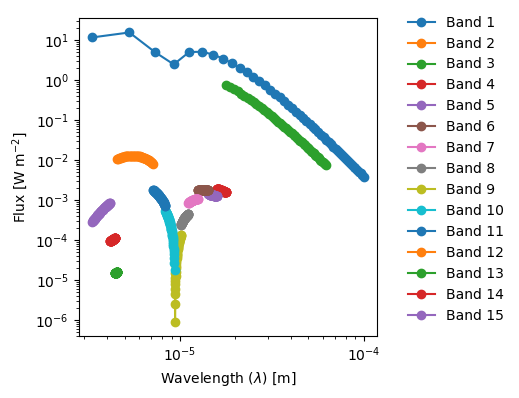

In [760]:
# Load all data for a given gas and atmospheric profiles
data_circ2 = load(gas_name='ALLGAS', atmosphere='CIRC2')
# Surface temperature, CIRC2 {K}
Ts_circ2 = 307.74
# Calculate fluxes, base temperatures
fluxes_circ2 = flux(Ts_circ2, bands='all')
print('CIRC2 flux emitted by surface: {0:.2f} W m^-2 | CIRC2 Stefan-Boltzmann: {1:.2f} W m^-2'.format(fluxes_circ2, sb(Ts_circ2)))

#### Pre-project, Problem 1, CIRC4

In [ ]:
# Load all data for a given gas and atmospheric profiles
data_circ2 = load(gas_name='ALLGAS', atmosphere='CIRC4')
# Surface temperature, CIRC2 {K}
Ts_circ2 = 266.65
# Calculate fluxes, base temperatures
fluxes_circ2 = flux(Ts_circ2, bands='all')
print('CIRC4 flux emitted by surface: {0:.2f} W m^-2 | CIRC4 Stefan-Boltzmann: {1:.2f} W m^-2'.format(fluxes_circ2, sb(Ts_circ2)))